In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
# types.txt has words each line adn vectors.txt has corresponding vectors
# load the word vector pairs into a dictionary

word_vectors = {}
types = open('word2vecTools/types.txt', 'r')
vectors = open('word2vecTools/vectors.txt', 'r')
for type, vector in zip(types, vectors):
    word_vectors[type.strip()] = np.array(vector.split(' ')).astype(float)

print(len(word_vectors))


1700935


In [3]:
sentences = []
with open('Genia4ERtraining/Genia4ERtask1.iob2', 'r') as f:
    data = f.read()
    sentence = []
    for line in data.split('\n'):
        if line.strip() == '':
            sentences.append(sentence)
            sentence = []
        else:
            sentence.append(tuple(line.split('\t')))

sentences = sentences[:100]
print(len(sentences))

100


In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Bidirectional, LSTM, Dense, Reshape

def get_combined_embeddings(word, word_vectors):
    # pad words to length 7 and above
    if len(word) < 7:
        word = word + '*' * (7 - len(word))

    # Create character embedding matrix
    embedding_dim = 100  # Dimensionality of character embeddings
    num_chars = 256  # Number of possible characters

    char_embedding_matrix = np.random.uniform(-1, 1, (num_chars, embedding_dim))

    # Define the input layer
    input_layer = Input(shape=(len(word),), dtype='int32')

    # Character-level representations - CNN
    filter_sizes = [3, 5, 7]  # Filter widths
    num_filters = 64  # Number of filters per filter size

    char_cnn_layers = []
    for filter_size in filter_sizes:
        char_embedding_layer = Embedding(input_dim=num_chars, output_dim=embedding_dim,
                                         weights=[char_embedding_matrix])(input_layer)

        char_conv_layer = Conv1D(filters=num_filters, kernel_size=filter_size)(char_embedding_layer)
        char_conv_layer = GlobalMaxPooling1D()(char_conv_layer)
        char_cnn_layers.append(char_conv_layer)

    char_cnn_representation = Concatenate()(char_cnn_layers)

    # Character-level representations - Bi-LSTM
    char_lstm_embedding_layer = Embedding(input_dim=num_chars, output_dim=embedding_dim,
                                          weights=[char_embedding_matrix])(input_layer)

    char_lstm_layer = Bidirectional(LSTM(units=64, return_sequences=False))(char_lstm_embedding_layer)

    # Word-level representation
    word_embedding_dim = 200 

    word_embedding = word_vectors.get(word, np.random.uniform(-1, 1, (word_embedding_dim,)))

    word_embedding = tf.expand_dims(word_embedding, axis=0)


    # Concatenate character-level and word-level representations
    combined_representation = Concatenate()([char_cnn_representation, char_lstm_layer, word_embedding])

    # Fully connected network
    fc_layer = Dense(units=200)(combined_representation)
    output_layer = Dense(units=200)(fc_layer)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer='adam')
    print(model.summary())
    return model.predict(np.array([[ord(c) for c in word]]))[0]


# Example usage
word = "hello"
embedding = get_combined_embeddings(word, word_vectors)
print(embedding.shape)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "functional_4733"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2367 (InputLayer)         [(None, 7)]          0                                            
__________________________________________________________________________________________________
embedding_9452 (Embedding)      (None, 7, 100)       25600       input_2367[0][0]      

In [5]:
len(word_vectors)

1700935

In [6]:
tags = list(set([tag for sentence in sentences for _, tag in sentence]))
n_tags = len(tags)
words = list(set([word for sentence in sentences for word, _ in sentence]))
words.append("PADword")
n_words = len(words)
print(n_words, n_tags)

# max length of a sentence
max_len = max([len(sentence) for sentence in sentences])
print('Maximum sentence length:', max_len)


789 11
Maximum sentence length: 70


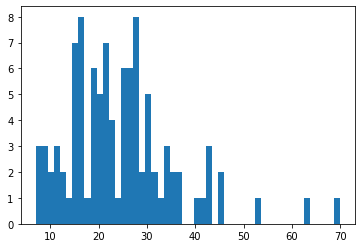

In [7]:
import matplotlib.pyplot as plt

plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.show()

In [8]:
max_len = 40
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(get_combined_embeddings(seq[i], word_vectors))
        except:
            new_seq.append(np.ones(200))
    new_X.append(new_seq)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
tags2index = {t:i for i,t in enumerate(tags)}
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=42)

In [26]:
# new_X : list of list of 200 dim vectors
# y : list of list of tags

# build a bi-lstm model

from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

input = Input(shape=(max_len, 200))
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(input)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

model = Model(input, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(np.array(X_train), np.array(y_train).reshape(len(y_train), max_len, 1), batch_size=32, epochs=40, validation_split=0.2, verbose=1)

# evaluate the model
model.evaluate(np.array(X_test), np.array(y_test).reshape(len(y_test), max_len, 1))


Epoch 1/40
2/2 [==============================] - 1s 505ms/step - loss: 2.1343 - accuracy: 0.3176 - val_loss: 1.5358 - val_accuracy: 0.5531
Epoch 2/40
2/2 [==============================] - 0s 45ms/step - loss: 1.3693 - accuracy: 0.6313 - val_loss: 1.3515 - val_accuracy: 0.6016
Epoch 3/40
2/2 [==============================] - 0s 44ms/step - loss: 1.2009 - accuracy: 0.6930 - val_loss: 1.2655 - val_accuracy: 0.6406
Epoch 4/40
2/2 [==============================] - 0s 56ms/step - loss: 1.1017 - accuracy: 0.7480 - val_loss: 1.1911 - val_accuracy: 0.6953
Epoch 5/40
2/2 [==============================] - 0s 58ms/step - loss: 1.0074 - accuracy: 0.7918 - val_loss: 1.1174 - val_accuracy: 0.7172
Epoch 6/40
2/2 [==============================] - 0s 51ms/step - loss: 0.9064 - accuracy: 0.8270 - val_loss: 1.0461 - val_accuracy: 0.7328
Epoch 7/40
2/2 [==============================] - 0s 52ms/step - loss: 0.8191 - accuracy: 0.8402 - val_loss: 0.9902 - val_accuracy: 0.7516
Epoch 8/40
2/2 [==========

[0.6734792590141296, 0.8587499856948853]